# Comparison of different tokenization approaches for strings

In this notebook we compare these 3 different methods for tokenizing a string (usually a first name, last name, city).

* **Method 1**: Generate q-grams with `q=2` and encode on a standard bloom filter with length `l=1000` and `k=100` hash functions.
* **Method 2**: Generate q-grams with `q=2` and encode on a bloom filter with length `l=1000` and a dynamic number of hash functions: $k = \frac{\ln(2)\cdot l}{\text{len}(q-grams)}$.
* **Method 3**: Generate q-grams with `q=2`, distinguishing equal q-grams that appear more than once; and then encoding in a dynamic bloom filter like Method 2.


## Discussion

We found out that Method 1 has a problem with short names. Short names have fewer q-grams, and thus fewer elements are inserted in the bloom filter, resulting in bloom filters with low number of 1s, and thus having less similarity once differential privacy is applied.

Method 2 greatly improves the stability for different name lengths, but has poor performance for names that have repeated q-grams. For example: `barbara` has these 2-grams `[ba, ar, rb, ba, ar, ra]`, with `ba` and `ar` appearing twice.

Method 3 encodes repeated q-grams as two different strings, and solves this issue (e.g. "barbara" is encoded as `[ba:1, ar:1, rb:1, ba:2, ar:2, ra:1]`).

In [1]:
import collections
import itertools
import math

from matplotlib import pyplot as plt

plt.rcParams["mathtext.fontset"] = "cm"
import numpy as np
import seaborn as sns
import pandas as pd

from tokenizer import dice, q_grams, tokenize

# Parameters
N = 5  # Number of tokens calculated for each name
L = 1000  # Bloom filter length
EPS = [1, 2, 3, 4]  # Differential privacy budget

def tokenize_name(name, eps, method):
    if method == 1:
        expanded = q_grams(name)
        return tokenize(L, 100, eps, expanded)
    elif method == 2:
        expanded = q_grams(name)
        k = 1 + int(L * math.log(2)) // len(expanded)
        return tokenize(L, k, eps, expanded)
    elif method == 3:
        expanded = q_grams(name)
        expanded = [
            f"{s}:{i}"
            for s, n in collections.Counter(expanded).most_common()
            for i in range(n)
        ]
        k = 1 + int(L * math.log(2)) // len(expanded)
        return tokenize(L, k, eps, expanded)
    elif method == 4:
        expanded = q_grams(name, q=3)
        expanded = [
            f"{s}:{i}"
            for s, n in collections.Counter(expanded).most_common()
            for i in range(n)
        ]
        k = 1 + int(L * math.log(2)) // len(expanded)
        return tokenize(L, k, eps, expanded)

In [2]:
# 4096 names from https://gist.github.com/elifiner/cc90fdd387449158829515782936a9a4
SAMPLE = 0
names = open("first-names.txt").read().splitlines()
names_df = pd.DataFrame(names, columns=["first_name"])
if SAMPLE > 0:
    names_df = names_df.sample(SAMPLE)
names_df["length"] = names_df.first_name.str.len()

# Create a dataframe with all the dice scores
df = pd.DataFrame(columns=["name", "eps", "dice_avg", "dice_std", "Method", "length"])
for eps in EPS:
    for row in names_df.itertuples():
        for method in [1, 2, 3, 4]:
            tokens = [
                tokenize_name(row.first_name, eps, method=method) for _ in range(N)
            ]
            dices = np.array([dice(a, b) for a, b in itertools.combinations(tokens, 2)])
            df.loc[len(df.index)] = [
                row.first_name,
                eps,
                dices.mean(),
                dices.std(),
                f"Method {method}",
                row.length,
            ]
avgs = pd.DataFrame(columns=["eps", "Method", "length", "dice_avg", "dice_std"])
for (eps, method, length), group in df.groupby(["eps", "Method", "length"]):
    avgs.loc[len(avgs.index)] = [
        eps,
        method,
        length,
        group.dice_avg.mean(),
        group.dice_std.mean(),
    ]

In [ ]:
#fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 5))
#fig.suptitle("Dice scores distributions for different name lengths")
#for ax, eps in zip(axs, EPS):
#    sns.boxplot(data=df[df.eps == eps], x="length", y="dice_avg", hue="Method", ax=ax)
#    ax.set_title(f"$\epsilon={eps}$")
#   ax.set_xlabel("Name length")
#   ax.set_ylabel("Dice score")

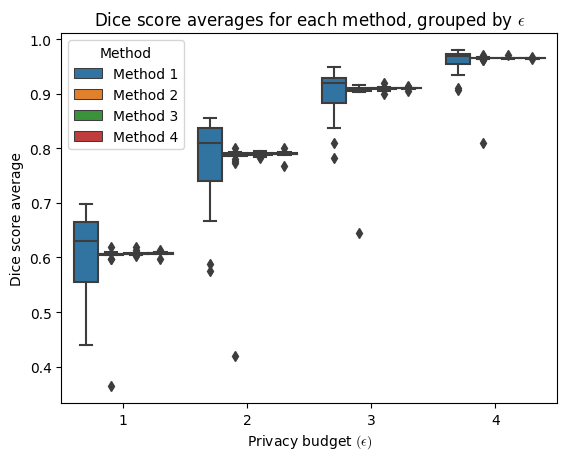

In [3]:
sns.boxplot(data=avgs, x="eps", y="dice_avg", hue="Method").set(title='Dice score averages for each method, grouped by $\epsilon$', xlabel='Privacy budget $(\epsilon)$', ylabel='Dice score average')
pass

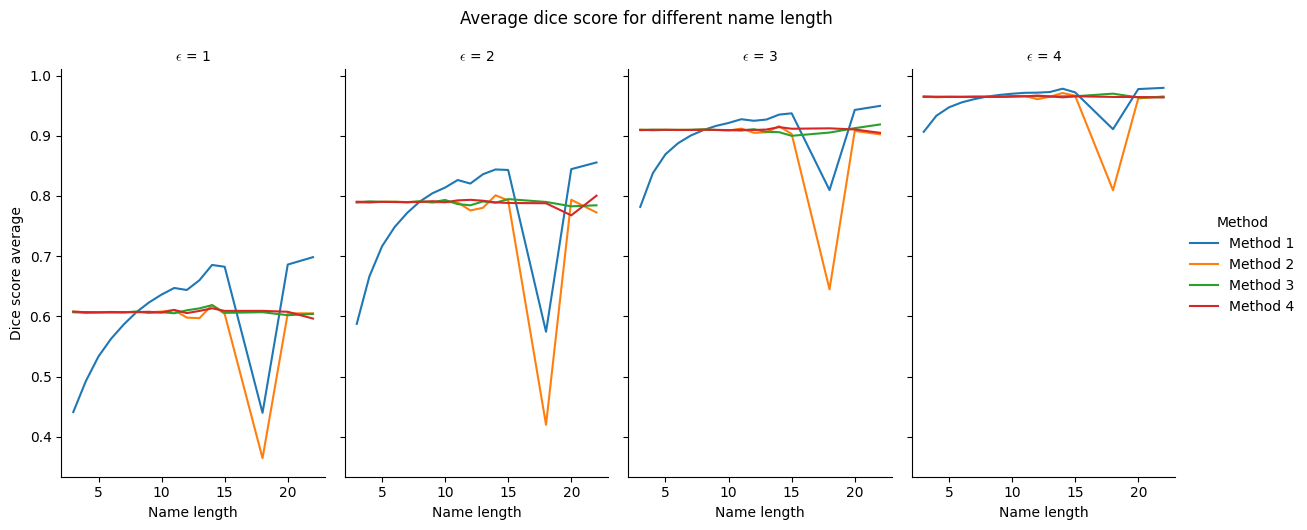

In [4]:
rel = sns.relplot(
    data=avgs,
    x="length",
    y="dice_avg",
    hue="Method",
    col="eps",
    kind="line",
    height=5,
    aspect=.6,
).set(xlabel="Name length", ylabel="Dice score average").set_titles("$\epsilon$ = {col_name}")
rel.fig.suptitle("Average dice score for different name length", y=1.05)
pass

In [5]:
print("Worst dice scores for Method 1")
print(df[(df.Method == "Method 1") & (df.eps == 3)].sort_values("dice_avg", ascending=True).head(10))
print("Worst dice scores for Method 2")
print(df[(df.Method == "Method 2") & (df.eps == 3)].sort_values("dice_avg", ascending=True).head(10))

Worst dice scores for Method 1
       name  eps  dice_avg  dice_std    Method  length
43272   me2    3  0.633127  0.021393  Method 1       3
47268   sr.    3  0.649583  0.019751  Method 1       3
36932   dr.    3  0.655764  0.030927  Method 1       3
42356   ma.    3  0.669785  0.029765  Method 1       3
43820   mr.    3  0.670190  0.014815  Method 1       3
35404   ch5    3  0.670950  0.025781  Method 1       3
43860   muy    3  0.759478  0.020530  Method 1       3
45500   ray    3  0.759715  0.017922  Method 1       3
47740  tata    3  0.761334  0.012252  Method 1       4
45676   rey    3  0.762169  0.013742  Method 1       3
Worst dice scores for Method 2
                     name  eps  dice_avg  dice_std    Method  length
41097  kikikikikikikikiki    3  0.644900  0.021937  Method 2      18
43941               nanan    3  0.839763  0.004557  Method 2       5
38721          guyenguyen    3  0.863153  0.007976  Method 2      10
41093                kiki    3  0.867628  0.009229  Metho

In [7]:
print("Worst dice scores for Method 3")
print(df[(df.Method == "Method 3") & (df.eps == 3)].sort_values("dice_avg", ascending=True).head(10))
print("Worst dice scores for Method 4")
print(df[(df.Method == "Method 4") & (df.eps == 3)].sort_values("dice_avg", ascending=True).head(10))

Worst dice scores for Method 3
                  name  eps  dice_avg  dice_std    Method  length
46134          ruchika    3  0.890226  0.007091  Method 3       7
42678           marcos    3  0.890677  0.009163  Method 3       6
38762            hadar    3  0.891459  0.005397  Method 3       5
46698          shakira    3  0.891545  0.013070  Method 3       7
35742            clara    3  0.892700  0.003570  Method 3       5
36286  danielazamorano    3  0.892841  0.006203  Method 3      15
45442           ramses    3  0.893041  0.007143  Method 3       6
44778             papa    3  0.893198  0.005976  Method 3       4
37782           faysal    3  0.893640  0.008635  Method 3       6
37334             emma    3  0.893651  0.007821  Method 3       4
Worst dice scores for Method 4
               name  eps  dice_avg  dice_std    Method  length
39455      isabelle    3  0.890766  0.005077  Method 4       8
40251      johannes    3  0.891527  0.004508  Method 4       8
37283     emanuelle    